In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

### Goals 
- Wrangle the Linkedin data from Kaggle
- Visualize cool findings

In [2]:
df = pd.read_csv('linkedin_data.csv')

In [3]:
df.describe()

,job_ID,company_id,Column1
count,7.927000e+03,0.0,0.0
mean,3.466724e+09,NaN,NaN
std,5.778011e+07,NaN,NaN
min,1.419216e+08,NaN,NaN
25%,3.467367e+09,NaN,NaN
50%,3.471882e+09,NaN,NaN
75%,3.476181e+09,NaN,NaN
max,3.477823e+09,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7927 entries, 0 to 7926
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   job_ID              7927 non-null   int64  
 1   job                 7894 non-null   object 
 2   location            7894 non-null   object 
 3   company_id          0 non-null      float64
 4   company_name        7892 non-null   object 
 5   work_type           7736 non-null   object 
 6   full_time_remote    7848 non-null   object 
 7   no_of_employ        7603 non-null   object 
 8   no_of_application   7887 non-null   object 
 9   posted_day_ago      7920 non-null   object 
 10  alumni              4858 non-null   object 
 11  Hiring_person       5720 non-null   object 
 12  linkedin_followers  4814 non-null   object 
 13  hiring_person_link  5720 non-null   object 
 14  job_details         7881 non-null   object 
 15  Column1             0 non-null      float64
dtypes: flo

In [5]:
df.isna().sum()

job_ID                   0
job                     33
location                33
company_id            7927
company_name            35
work_type              191
full_time_remote        79
no_of_employ           324
no_of_application       40
posted_day_ago           7
alumni                3069
Hiring_person         2207
linkedin_followers    3113
hiring_person_link    2207
job_details             46
Column1               7927
dtype: int64

## Data Cleaning Steps 
- Drop columns that do not provide extra context to the data set
- Make a Salary column from the job column 
- Make a city, state and country column from the location
- Industry column from the no_of_employ
- Catgeorize the no_of_employ to be (1 - 10, 11 - 100, 101 - 1000, 1000 - 5000, 5000+) categories

In [6]:
df[['city', 'state', 'country']] = df['location'].str.split(',', expand=True) 

In [7]:
def extract_employee_range(text): 
    if pd.isna(text): 
        return np.nan, np.nan
    parts = text.split('·')
    employees = parts[0].replace(',', '').split('-')
    # Does not have a range
    if len(employees) == 1: 
        if '+' in employees[0]:
            return (5001, '5000+')
        return (int(employees[0]), employees[0])
    else: 
        if 'employees' in employees[1]:
            employees[1] = employees[1].replace(' employees', '')
        return (int(employees[0]), employees[1])
    
def categorize_employees(empl_range): 
    if pd.isna(empl_range): 
        return 'Unknown'
    min_empl = int(empl_range) 
    if empl_range == 0: 
        return 'Unknown'                                           
    if min_empl < 11:
        return '1-10'
    elif min_empl < 101:
        return '11-100'
    elif min_empl < 1001:
        return '101-1000'
    elif min_empl < 5001:
        return '1001-5000'
    else:
        return '5000+'

In [8]:
# Apply functions 
df['range'], df['employee_count'] = zip(*df['no_of_employ'].apply(extract_employee_range))
df['range'] = pd.to_numeric(df['range'], errors = 'coerce').fillna(0).astype('int')
df['employee_bucket'] = df['range'].apply(categorize_employees)
df['industry'] = df['no_of_employ'].str.split(' · ').str.get(1).fillna('Unknown')

# Show the resulting DataFrame
df[['no_of_employ', 'industry', 'employee_bucket']]

,no_of_employ,industry,employee_bucket
0,"1,001-5,000 employees · IT Services and IT Con...",IT Services and IT Consulting,1001-5000
1,"1,001-5,000 employees · IT Services and IT Con...",IT Services and IT Consulting,1001-5000
2,"1,001-5,000 employees · IT Services and IT Con...",IT Services and IT Consulting,1001-5000
3,1-10 employees,Unknown,1-10
4,1-10 employees,Unknown,1-10
...,...,...,...
7922,"5,001-10,000 employees · IT Services and IT Co...",IT Services and IT Consulting,5000+
7923,"1,001-5,000 employees · IT Services and IT Con...",IT Services and IT Consulting,1001-5000
7924,"10,001+ employees · IT Services and IT Consulting",IT Services and IT Consulting,5000+
7925,"1,001-5,000 employees · IT Services and IT Con...",IT Services and IT Consulting,1001-5000


In [9]:
# Clean 'full_time_remote' column
df[['work_schedule', 'work_level']] = df['full_time_remote'].str.split('·', expand=True)  # Split work schedule and work level into separate columns
df.drop('full_time_remote', axis=1, inplace=True)  # Drop original 'full_time_remote' column

In [10]:
df.head()

,job_ID,job,location,company_id,company_name,work_type,no_of_employ,no_of_application,posted_day_ago,alumni,...,Column1,city,state,country,range,employee_count,employee_bucket,industry,work_schedule,work_level
0,3471657636,"Data Analyst, Trilogy (Remote) - $60,000/year USD","Delhi, Delhi, India",NaN,Crossover,Remote,"1,001-5,000 employees · IT Services and IT Con...",200,8 hours,12 company alumni,...,NaN,Delhi,Delhi,India,1001,5000,1001-5000,IT Services and IT Consulting,Full-time,Associate
1,3471669068,"Data Analyst, Trilogy (Remote) - $60,000/year USD","New Delhi, Delhi, India",NaN,Crossover,Remote,"1,001-5,000 employees · IT Services and IT Con...",184,8 hours,12 company alumni,...,NaN,New Delhi,Delhi,India,1001,5000,1001-5000,IT Services and IT Consulting,Full-time,Associate
2,3474349934,Data Analyst - WFH,Greater Bengaluru Area,NaN,Uplers,Remote,"1,001-5,000 employees · IT Services and IT Con...",200,9 hours,3 company alumni,...,NaN,Greater Bengaluru Area,None,None,1001,5000,1001-5000,IT Services and IT Consulting,Full-time,Mid-Senior level
3,3472816027,Data Analyst,"Gurugram, Haryana, India",NaN,PVAR SERVICES,On-site,1-10 employees,200,7 hours,NaN,...,NaN,Gurugram,Haryana,India,1,10,1-10,Unknown,Full-time,None
4,3473311511,Data Analyst,"Mohali district, Punjab, India",NaN,Timeline Freight Brokers,On-site,1-10 employees,8,26 minutes,1 company alumni,...,NaN,Mohali district,Punjab,India,1,10,1-10,Unknown,Full-time,None


In [11]:
# Remove duplicate entries
df.drop_duplicates(keep='first', inplace=True)

In [12]:
# returns number from a text 
def get_number(string): 
    if pd.isnull(string): 
        return np.nan
    else: 
        num = re.findall(r'[0-9]+', string)
        return int(num[0]) if num else np.nan
    
# Clean 'no_of_application' column
df['no_of_application'] = df['no_of_application'].apply(get_number) 


In [13]:
df['employee_count'].unique()

array(['5000 ', '10', '5000+', '200', '500', nan, '50', '1000 ', '5000',
       '10000 ', '200 ', '1000', '50 ', '10 ', '500 ', '10000'],
      dtype=object)

In [14]:
# Strip text within parentheses
df['job'] = df['job'].apply(lambda x: re.sub(r'\(.*\)', '', x) if pd.notnull(x) else np.nan)  

def capitalize_str(string): 
    if pd.isnull(string): 
        return np.nan
    else: 
        return string.strip().capitalize()
    
# Clean 'Job' column

# Remove text within parentheses
df['job'] = df['job'].apply(lambda x: re.sub(r'\(.*\)', '', x) if pd.notnull(x) else np.nan) 
 # Remove yearly package info
df['job'] = df['job'].apply(lambda x: re.sub(r'- \$[0-9,]+/year USD', '', x) if pd.notnull(x) else np.nan)
 # Remove text after comma
df['job'] = df['job'].apply(lambda x: re.sub(r',.*', '', x) if pd.notnull(x) else np.nan) 
df['job'] = df['job'].apply(capitalize_str)  # Standardize the text


In [15]:
df['company_name'] = df['company_name'].apply(capitalize_str)  # Standardize the text

In [16]:
df.drop(columns = ['location', 'country',
                  'Column1', 'Hiring_person', 'linkedin_followers', 'company_id',
                'alumni', 'hiring_person_link', 'job_details', 'posted_day_ago'] ,
        inplace = True)

## Visualizations

In [17]:
df

,job_ID,job,company_name,work_type,no_of_employ,no_of_application,city,state,range,employee_count,employee_bucket,industry,work_schedule,work_level
0,3471657636,Data analyst,Crossover,Remote,"1,001-5,000 employees · IT Services and IT Con...",200.0,Delhi,Delhi,1001,5000,1001-5000,IT Services and IT Consulting,Full-time,Associate
1,3471669068,Data analyst,Crossover,Remote,"1,001-5,000 employees · IT Services and IT Con...",184.0,New Delhi,Delhi,1001,5000,1001-5000,IT Services and IT Consulting,Full-time,Associate
2,3474349934,Data analyst - wfh,Uplers,Remote,"1,001-5,000 employees · IT Services and IT Con...",200.0,Greater Bengaluru Area,None,1001,5000,1001-5000,IT Services and IT Consulting,Full-time,Mid-Senior level
3,3472816027,Data analyst,Pvar services,On-site,1-10 employees,200.0,Gurugram,Haryana,1,10,1-10,Unknown,Full-time,None
4,3473311511,Data analyst,Timeline freight brokers,On-site,1-10 employees,8.0,Mohali district,Punjab,1,10,1-10,Unknown,Full-time,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7922,3472039871,Back end developer,Orion innovation,Hybrid,"5,001-10,000 employees · IT Services and IT Co...",25.0,Kochi,Kerala,5001,10000,5000+,IT Services and IT Consulting,Full-time,Associate
7923,3473194471,Software engineer - senior,Uplers,On-site,"1,001-5,000 employees · IT Services and IT Con...",18.0,Gurugram,Haryana,1001,5000,1001-5000,IT Services and IT Consulting,Full-time,Mid-Senior level
7924,3461005032,Vue js,Tata consultancy services,On-site,"10,001+ employees · IT Services and IT Consulting",15.0,Hyderabad,Telangana,5001,5000+,5000+,IT Services and IT Consulting,Full-time,Mid-Senior level
7925,3474305684,Ios developer,Uplers,Remote,"1,001-5,000 employees · IT Services and IT Con...",17.0,Bengaluru,Karnataka,1001,5000,1001-5000,IT Services and IT Consulting,Full-time,Mid-Senior level


In [18]:
df.to_csv('linkedin_final.csv')

In [19]:
df['work_type'].value_counts()

On-site    3211
Remote     2983
Hybrid     1466
Name: work_type, dtype: int64

In [20]:
df.shape

(7848, 14)

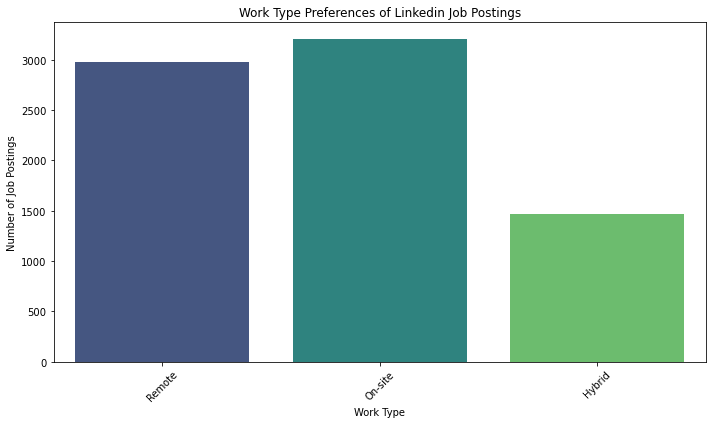

In [21]:
# Basic cleanup for visualization
df['work_type'] = df['work_type'].str.strip()  # Removing any leading/trailing spaces

# Plotting Work Type Preferences
plt.figure(figsize=(10, 6))
sns.countplot(x='work_type', data=df, palette='viridis')
plt.title('Work Type Preferences of Linkedin Job Postings')
plt.xlabel('Work Type')
plt.ylabel('Number of Job Postings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

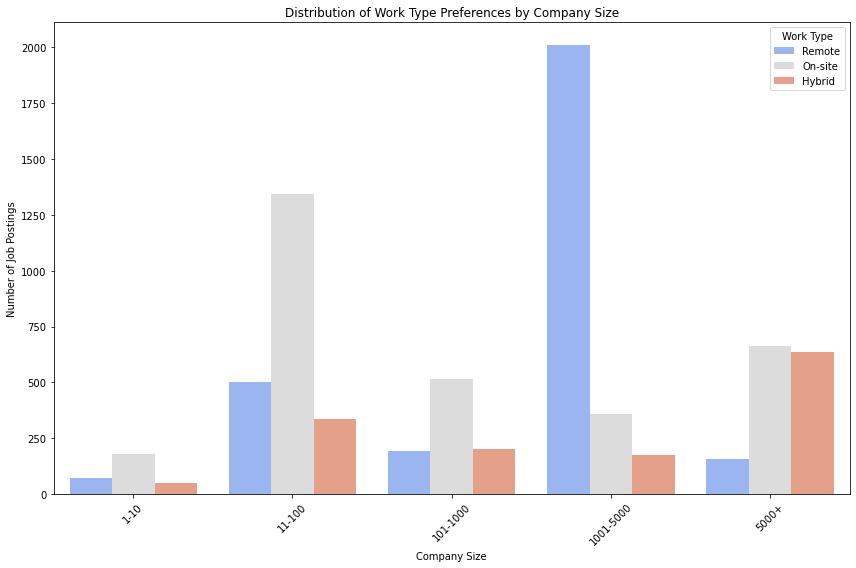

In [22]:
df['employee_bucket'] = pd.Categorical(df['employee_bucket'], categories=[
    '1-10', '11-100', '101-1000', '1001-5000', '5000+'
], ordered=True)


plt.figure(figsize=(12, 8))
sns.countplot(x='employee_bucket', hue='work_type', data=df, palette='coolwarm')
plt.title('Distribution of Work Type Preferences by Company Size')
plt.xlabel('Company Size')
plt.ylabel('Number of Job Postings')
plt.xticks(rotation=45)
plt.legend(title='Work Type')
plt.tight_layout()
plt.show()


0.5051546391752577

In [24]:
df['work_type'] =df['work_type'].str.strip()  
df['work_level'] = df['work_level'].str.strip()  
dat = df[df['work_level'].isin(['Internship', 'Entry level', 'Associate'])]
dat[dat['work_level'] == 'Entry level'].groupby('work_type').count()

,job_ID,job,company_name,no_of_employ,no_of_application,city,state,range,employee_count,employee_bucket,industry,work_schedule,work_level
work_type,,,,,,,,,,,,,
Hybrid,45,45,45,45,23,45,41,45,45,45,45,45,45
On-site,98,98,98,97,48,98,92,98,97,97,98,98,98
Remote,51,51,51,51,30,51,16,51,51,51,51,51,51


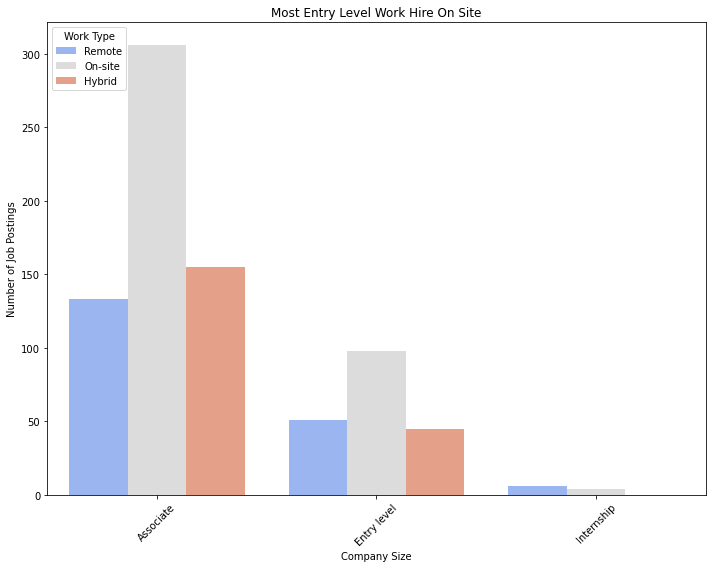

In [25]:
plt.figure(figsize=(10, 8))
sns.countplot(x='work_level', hue='work_type', data=df[df['work_level'].isin(['Internship', 'Entry level', 'Associate'])],palette='coolwarm')
plt.title('Most Entry Level Work Hire On Site')
plt.xlabel('Company Size')
plt.ylabel('Number of Job Postings')
plt.xticks(rotation=45)
plt.legend(title='Work Type')
plt.tight_layout()
plt.show()


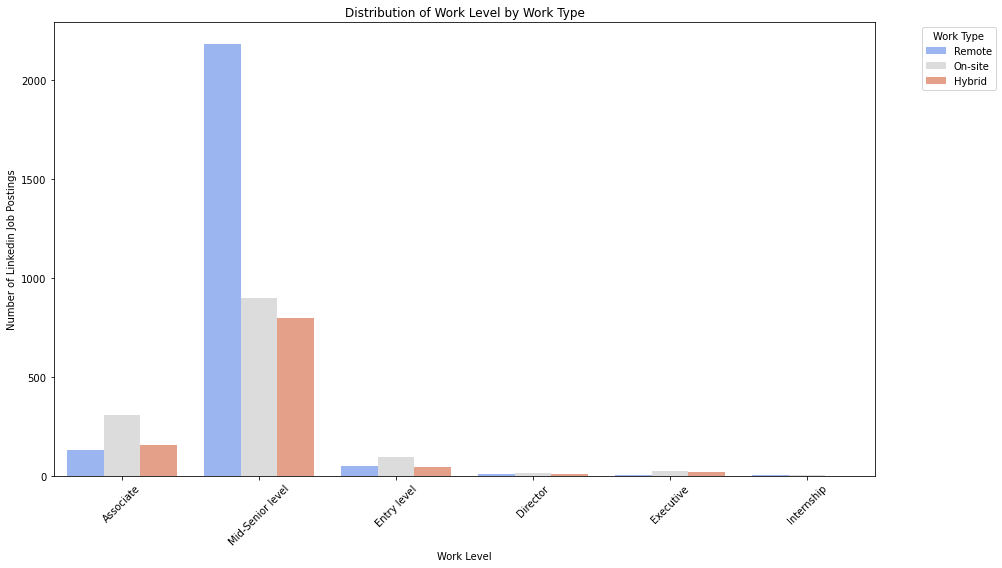

In [26]:
# Dropping any missing values for better visualization
df.dropna(subset=['work_type', 'work_level'], inplace=True)

plt.figure(figsize=(14, 8))
sns.countplot(x='work_level', hue='work_type', data=df, palette='coolwarm')
plt.title('Distribution of Work Level by Work Type')
plt.xlabel('Work Level')
plt.ylabel('Number of Linkedin Job Postings')
plt.legend(title='Work Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

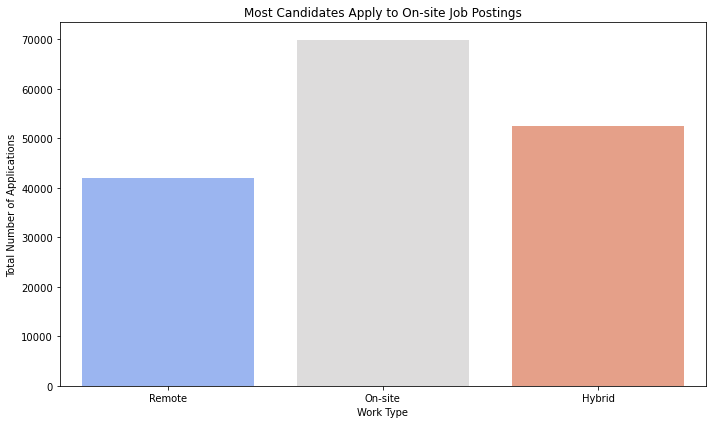

In [27]:
plt.figure(figsize=(10, 6))
sns.barplot(x='work_type', y='no_of_application', data=df, estimator=sum, ci=None, palette='coolwarm')
plt.title('Most Candidates Apply to On-site Job Postings')
plt.xlabel('Work Type')
plt.ylabel('Total Number of Applications')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

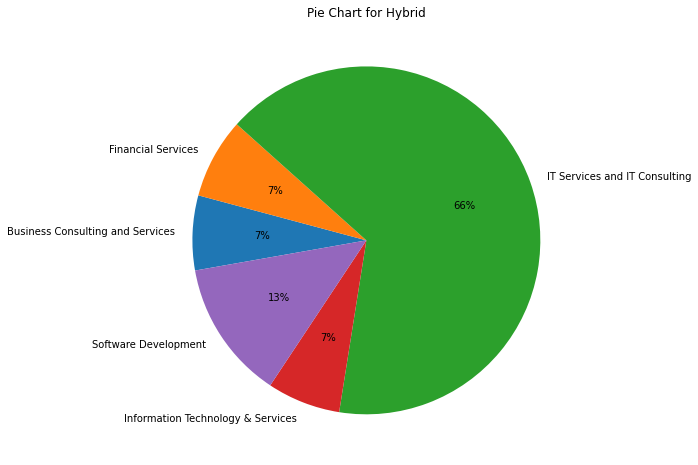

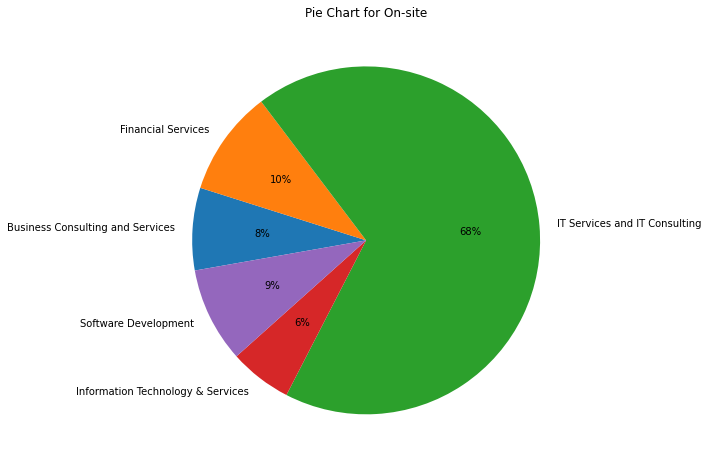

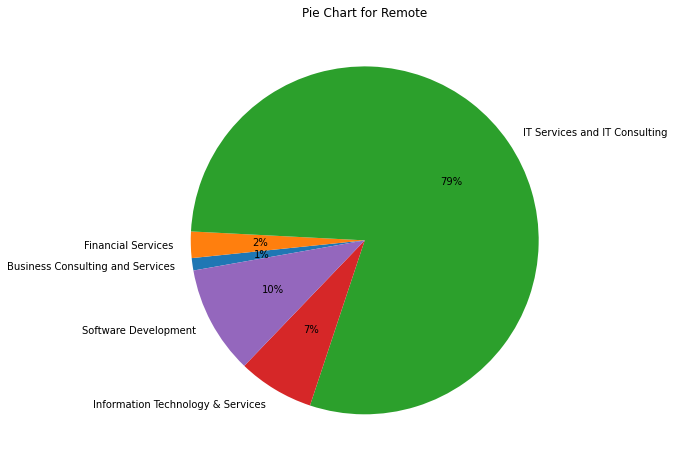

In [28]:
# Calculate total applications by industry
total_applications_by_industry = df.groupby('industry')['no_of_application'].sum()

# Get the top 10 industries with the highest number of applications
top_industries = total_applications_by_industry.nlargest(5).index

# Filter the original data to include only these top 10 industries
filtered_data = df[df['industry'].isin(top_industries)]

# Group filtered data by 'work_type' and 'industry' and calculate the total 'no_of_application'
grouped_data = filtered_data.groupby(['work_type', 'industry'])['no_of_application'].sum().unstack(fill_value=0)

# Plotting one pie chart for each work type
for work_type, values in grouped_data.iterrows():
    plt.figure(figsize=(10, 8))
    values.plot.pie(autopct='%1.0f%%', startangle=190, counterclock=False, title=f'Pie Chart for {work_type}')
    plt.ylabel('')  # Remove the y-label as it's unnecessary
    plt.show()


In [29]:
df.columns

Index(['job_ID', 'job', 'company_name', 'work_type', 'no_of_employ',
       'no_of_application', 'city', 'state', 'range', 'employee_count',
       'employee_bucket', 'industry', 'work_schedule', 'work_level'],
      dtype='object')

In [30]:
salaries = pd.read_csv('salaries.csv')

In [31]:
salaries = salaries[['salary', 'job_title', 'salary_currency', 'company_size']]

## Enrichment with Matching Algorithm 

Our original data set has linkedin job postings without any salary or compensation element. We enriched this with another open source data set that had the needed information

In [32]:
from collections import Counter

def match_titles(linkedin_title, salary_titles):
    """
    Match job titles from LinkedIn data to the closest title from Salary data based on
    the condition that at least two words match between titles.
    """
    linkedin_words = set(linkedin_title.lower().split())
    best_match = None
    max_common = 1  # Start with 1 to ensure at least two words match

    for title in salary_titles:
        title_words = set(title.lower().split())
        common_words = len(linkedin_words & title_words)
        if common_words > max_common:
            max_common = common_words
            best_match = title

    return best_match if max_common >= 2 else None

# Create a set of unique job titles from the salary data for efficient searching
salary_titles = set(salaries['job_title'])

# Apply the matching function to each job in LinkedIn data to find the corresponding salary job title
df['matched_job_title'] = df['job'].apply(lambda x: match_titles(x, salary_titles))

# Merge the datasets based on the matched job title
merged_data = df.merge(salaries, left_on='matched_job_title', right_on='job_title', how='left')


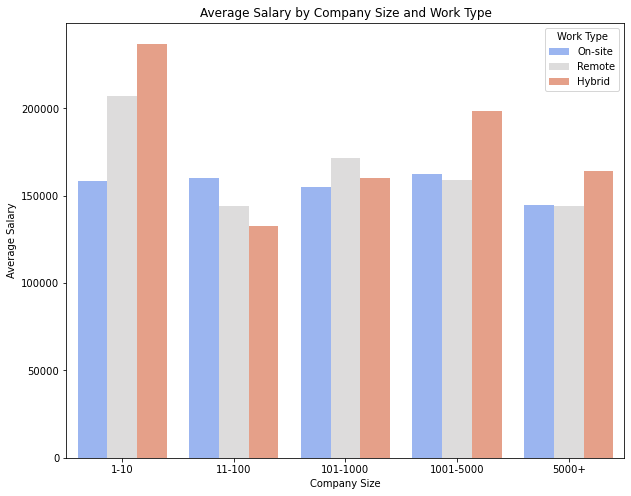

In [33]:
average_salary = merged_data.groupby(['employee_bucket', 'work_type'])['salary'].mean().reset_index()
average_salary['sort_key'] = average_salary.groupby('employee_bucket')['salary'].transform(max)
average_salary_sorted = average_salary.sort_values(by=['sort_key', 'salary'], 
                                                   ascending=[True, False]).drop('sort_key', axis=1)


plt.figure(figsize=(10, 8))
sns.barplot(x='employee_bucket', y='salary', hue = 'work_type', palette = 'coolwarm', data=average_salary_sorted)
plt.title('Average Salary by Company Size and Work Type')
plt.xlabel('Company Size')
plt.ylabel('Average Salary')
plt.legend(title='Work Type')
plt.show()

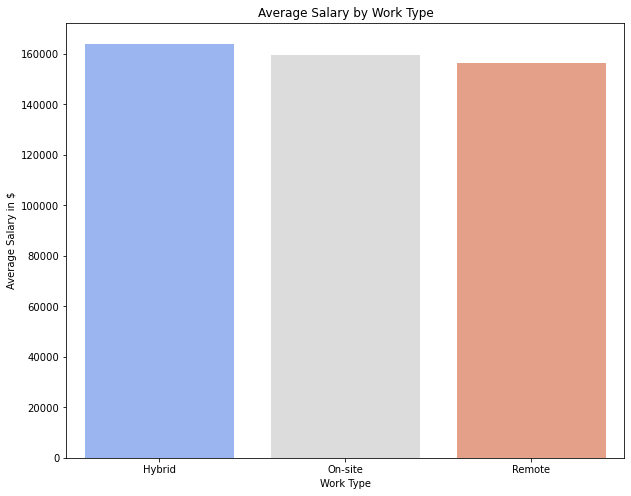

In [34]:
average_salary = merged_data.groupby('work_type')['salary'].mean().reset_index()
plt.figure(figsize=(10, 8))
sns.barplot(x='work_type', y='salary', palette = 'coolwarm', data=average_salary)
plt.title('Average Salary by Work Type')
plt.xlabel('Work Type')
plt.ylabel('Average Salary in $')
plt.show()